# Installs/Imports

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 23 20:37:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
! pip install torch==2.0.0
! pip install torchaudio==2.0.1
! pip install torchdata==0.6.0
! pip install torchtext==0.15.1
! pip install torchvision==0.15.1
! pip install pytorch-tabnet 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━

In [4]:
import os
import random
import time
import psutil
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV , train_test_split
from sklearn.decomposition import PCA

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read

In [6]:
train = pd.read_parquet('/content/drive/MyDrive/TabNet/train.parquet')
train['S_2'] = pd.to_datetime(train['S_2']).astype('datetime64[ns]')

train = train.groupby('customer_ID').tail(1).reset_index(drop=True)
train = train.fillna(-1)

print(train.shape)
display(train.head())

(458913, 190)


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,...,-1,-1,-1,0,0,0.0,-1.0,0,0.002970,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,...,-1,-1,-1,0,0,0.0,-1.0,0,0.003169,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,0.880875,0,0.004284,0.812649,0.006450,-1.000000,0.0,0.007196,...,-1,-1,-1,0,0,0.0,-1.0,0,0.000834,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,...,-1,-1,-1,0,0,0.0,-1.0,0,0.005560,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,0.871900,0,0.007679,0.815746,0.001247,-1.000000,0.0,0.005528,...,-1,-1,-1,0,0,0.0,-1.0,0,0.006944,0


# Feature engineer

In [7]:
def process_and_feature_engineer(df):

    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = pd.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

train = process_and_feature_engineer(train)

shape after engineering (458913, 918)


In [8]:
train.head(5)

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.934745,NaN,0.934745,0.934745,0.934745,0.0,NaN,0,0,0,...,1,1,0,1,1,-1,1,1,6,1
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.880519,NaN,0.880519,0.880519,0.880519,6.0,NaN,6,6,6,...,1,1,0,1,1,-1,1,1,6,1
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.880875,NaN,0.880875,0.880875,0.880875,0.0,NaN,0,0,0,...,1,1,2,1,1,-1,1,1,6,1
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.621776,NaN,0.621776,0.621776,0.621776,0.0,NaN,0,0,0,...,1,1,0,1,1,-1,1,1,3,1
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.871900,NaN,0.871900,0.871900,0.871900,0.0,NaN,0,0,0,...,1,1,0,1,1,1,1,1,6,1


# CFG

In [9]:
class CFG:
  # DEBUG = True
  DEBUG = False
  model = 'tabnet'
  N_folds = 5
  seed = 42

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed = CFG.seed)

In [11]:
psutil.virtual_memory().percent

5.6

# Features and Target

In [12]:
targets = pd.read_csv('/content/drive/MyDrive/TabNet/train_labels.csv')
targets = targets.set_index('customer_ID')
train_new = train.merge(targets, how='left', left_index=True, right_index=True)
train_new['target'] = train_new['target'].astype('int8')

train_new = train_new.sort_index().reset_index()

FEATURES = train_new.columns[1:-1]

print('target shape: ', targets.shape)
print('train shape: ', train_new.shape)
print(f'There are {len(FEATURES)} features!')

target shape:  (458913, 1)
train shape:  (458913, 920)
There are 918 features!


In [13]:
train_new.head(10)

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.934745,NaN,0.934745,0.934745,0.934745,0.0,NaN,0,0,...,1,0,1,1,-1,1,1,6,1,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.880519,NaN,0.880519,0.880519,0.880519,6.0,NaN,6,6,...,1,0,1,1,-1,1,1,6,1,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.880875,NaN,0.880875,0.880875,0.880875,0.0,NaN,0,0,...,1,2,1,1,-1,1,1,6,1,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.621776,NaN,0.621776,0.621776,0.621776,0.0,NaN,0,0,...,1,0,1,1,-1,1,1,3,1,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.871900,NaN,0.871900,0.871900,0.871900,0.0,NaN,0,0,...,1,0,1,1,1,1,1,6,1,0
5,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,0.824061,NaN,0.824061,0.824061,0.824061,0.0,NaN,0,0,...,1,2,1,1,-1,1,1,6,1,0
6,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.477116,NaN,0.477116,0.477116,0.477116,0.0,NaN,0,0,...,1,2,1,1,-1,1,1,3,1,0
7,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,1.009762,NaN,1.009762,1.009762,1.009762,0.0,NaN,0,0,...,1,2,1,1,-1,1,1,5,1,0
8,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,0.424624,NaN,0.424624,0.424624,0.424624,18.0,NaN,18,18,...,1,3,1,1,1,1,1,6,1,1
9,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,0.359892,NaN,0.359892,0.359892,0.359892,0.0,NaN,0,0,...,1,0,1,1,-1,1,1,5,1,1


In [14]:
all_features = [col for col in train_new.columns if col not in ['target', 'customer_ID', 'S_2']]
n_features = len(all_features)
print('n features: ', n_features)

n features:  918


In [15]:
X = train_new[all_features]
X = X.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y = train_new['target']

display(X.head())

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
0,0.934745,0.0,0.934745,0.934745,0.934745,0.0,0.0,0,0,0,...,1,1,0,1,1,-1,1,1,6,1
1,0.880519,0.0,0.880519,0.880519,0.880519,6.0,0.0,6,6,6,...,1,1,0,1,1,-1,1,1,6,1
2,0.880875,0.0,0.880875,0.880875,0.880875,0.0,0.0,0,0,0,...,1,1,2,1,1,-1,1,1,6,1
3,0.621776,0.0,0.621776,0.621776,0.621776,0.0,0.0,0,0,0,...,1,1,0,1,1,-1,1,1,3,1
4,0.871900,0.0,0.871900,0.871900,0.871900,0.0,0.0,0,0,0,...,1,1,0,1,1,1,1,1,6,1


In [16]:
X.isna().sum()

P_2_mean        0
P_2_std         0
P_2_min         0
P_2_max         0
P_2_last        0
               ..
D_66_last       0
D_66_nunique    0
D_68_count      0
D_68_last       0
D_68_nunique    0
Length: 918, dtype: int64

# Metric

I will use [Vopani's implementation](https://www.kaggle.com/code/rohanrao/amex-competition-metric-implementations).

In [17]:
def amex_metric_numpy(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

In [18]:
# using amex metric to evaluate tabnet
class Amex_tabnet(Metric):
    
  def __init__(self):
    self._name = 'amex_tabnet'
    self._maximize = True

  def __call__(self, y_true, y_pred):
    amex = amex_metric_numpy(y_true, y_pred[:, 1])
    return max(amex, 0.)

In [ ]:
# using amex metric to evaluate transformers
class Amex_transf(Metric):
    
  def __init__(self):
    self._name = 'amex_transf'
    self._maximize = True

  def __call__(self, y_true, y_pred):
    amex = amex_metric_numpy(y_true, y_pred[:, 0])
    return max(amex, 0.)

# Tuning hyperparameters (GS)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV, KFold
# from sklearn.model_selection import ParameterGrid
# import torch.optim
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from torch.optim.lr_scheduler import OneCycleLR
# from torchvision import transforms
# import torch
# from pytorch_tabnet.tab_model import TabNetClassifier
# from pytorch_tabnet.metrics import Metric
# import random
# from tqdm import tqdm

# # Define the grid search parameters

# param_grid = {
#     'n_d': [32, 64],
#     'n_a': [32, 64],
#     'n_steps': [3, 5],
#     'gamma': [0.9 , 1.2, 1.3],
#     'n_independent': [1, 2],
#     'n_shared': [1, 2],
#     'momentum': [0.02 , 0.1],
#     'clip_value': [None],
#     'lambda_sparse': [0.0009 , 0.0001],
#     'optimizer_fn': [torch.optim.Adam],
#     'scheduler_fn': [torch.optim.lr_scheduler.CosineAnnealingLR],
#      'scheduler_params' : [{"T_max" : 6}],
#     'mask_type': ['entmax'], #sparsemax показал результат хуже в прошлом переборе
#     'seed': [CFG.seed]}


# X = train[all_features] 
# y = train['target']

# X_train, X_valid, y_train, y_valid = train_test_split(train[all_features], train['target'], test_size=0.2, random_state=42)

# models = []
# scores = []

# # Perform grid search
# for params in tqdm(list(ParameterGrid(param_grid))):
#     model = TabNetClassifier(**params)
#     model.fit(
#         X_train=X_train.values,
#         y_train=y_train.values.ravel(),
#         eval_set=[(X_valid.values, y_valid.values.ravel())],
#         eval_metric=['auc' , Amex_tabnet],
#         max_epochs=10,
#         patience=5,
#         batch_size=2048,
#         virtual_batch_size=128,
#         num_workers=0,
#         drop_last=False)
    
#     pred = model.predict_proba(X_valid.values)
#     amex = Amex_tabnet()(y_valid.values, pred)
#     models.append(model)
#     scores.append(amex)

In [ ]:
# best_idx = np.argmax(scores)
# best_model = models[best_idx]
# best_score = scores[best_idx]
# best_params = best_model.get_params()

# print(f"Best score: {best_score}")
# print(f"Best parameters: {best_params}")

In [ ]:
# models[np.argmax(scores)]

# Applying PCA (worse results)

In [ ]:
# pca = PCA(n_components=100)

# X = pca.fit_transform(X)
# X = pd.DataFrame(data = X)
# n_rows , n_col = X.shape

In [20]:
type(X)

pandas.core.frame.DataFrame

# Training with the best params 

In [ ]:
def run_training(X = X, y = y, nfolds = CFG.N_folds):

    print('\n ', '-'*50)
    print('\nTraining: ', CFG.model)
    print('\n ', '-'*50)

    print('\nSeed: ', CFG.seed)
    print('N folds: ', CFG.N_folds)
    print('train shape: ', X.shape)
    print('targets shape: ', y.shape)


    print('\nN features: ', len(all_features))
    print('\n')

    models = list()
    
    kfold = StratifiedKFold(n_splits = CFG.N_folds, shuffle=True, random_state = CFG.seed)

    for k, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):

        ## DEBUG MODE
        if CFG.DEBUG == True:
            if k > 0:
                print('\nDEBUG mode activated: Will train only one fold...\n')
                break      

        start = time.time()

        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_valid, y_valid = X.loc[valid_idx], y.loc[valid_idx]        
        
        model = TabNetClassifier(n_d = 32,
                                 n_a = 64,
                                 n_steps = 3,
                                 gamma = 1.3,                                 
                                 n_independent = 2,
                                 n_shared = 2,
                                 momentum = 0.02,
                                 clip_value = None,
                                 lambda_sparse = 0.0009,
                                 optimizer_fn = torch.optim.Adam,
                                 scheduler_fn = torch.optim.lr_scheduler.CosineAnnealingLR,
                                 scheduler_params = {"T_max" : 6},
                                 mask_type = 'entmax',
                                 seed = CFG.seed)

        ## train
        model.fit(np.array(X_train),
                  np.array(y_train.values.ravel()),
                  eval_set = [(np.array(X_valid), np.array(y_valid.values.ravel()))],
                  max_epochs = 50,
                  patience = 10,
                  batch_size = 1024,
                  eval_metric = ['auc', 'accuracy', Amex_tabnet])

        models.append(model)

        end = time.time()
        time_delta = np.round((end - start)/60, 2)
     
        print(f'\nFold {k+1}/{CFG.N_folds} | {time_delta:.2f} min')

        ### free memory
        del X_train, y_train
        del X_valid, y_valid
        gc.collect()

    return models

In [ ]:
%%time

### RUN TRAINING: 
models = run_training()


  --------------------------------------------------

Training:  tabnet

  --------------------------------------------------

Seed:  42
N folds:  5
train shape:  (458913, 918)
targets shape:  (458913,)

N features:  918




/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.29913 | val_0_auc: 0.95218 | val_0_accuracy: 0.88779 | val_0_amex_tabnet: 0.75711 |  0:00:22s
epoch 1  | loss: 0.2496  | val_0_auc: 0.9546  | val_0_accuracy: 0.89457 | val_0_amex_tabnet: 0.76648 |  0:00:44s
epoch 2  | loss: 0.24215 | val_0_auc: 0.95647 | val_0_accuracy: 0.89714 | val_0_amex_tabnet: 0.77533 |  0:01:06s
epoch 3  | loss: 0.23731 | val_0_auc: 0.95706 | val_0_accuracy: 0.89789 | val_0_amex_tabnet: 0.77629 |  0:01:27s
epoch 4  | loss: 0.23485 | val_0_auc: 0.95765 | val_0_accuracy: 0.89882 | val_0_amex_tabnet: 0.78002 |  0:01:49s
epoch 5  | loss: 0.23214 | val_0_auc: 0.95813 | val_0_accuracy: 0.8989  | val_0_amex_tabnet: 0.78042 |  0:02:10s
epoch 6  | loss: 0.23165 | val_0_auc: 0.95808 | val_0_accuracy: 0.89892 | val_0_amex_tabnet: 0.78049 |  0:02:32s
epoch 7  | loss: 0.23154 | val_0_auc: 0.95818 | val_0_accuracy: 0.89935 | val_0_amex_tabnet: 0.78021 |  0:02:54s
epoch 8  | loss: 0.23585 | val_0_auc: 0.9567  | val_0_accuracy: 0.89761 | val_0_amex_tabnet: 0.7

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Fold 1/5 | 16.37 min


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.29491 | val_0_auc: 0.95068 | val_0_accuracy: 0.88985 | val_0_amex_tabnet: 0.74833 |  0:00:21s
epoch 1  | loss: 0.24828 | val_0_auc: 0.95359 | val_0_accuracy: 0.89304 | val_0_amex_tabnet: 0.76094 |  0:00:42s
epoch 2  | loss: 0.24113 | val_0_auc: 0.95515 | val_0_accuracy: 0.89355 | val_0_amex_tabnet: 0.76606 |  0:01:04s
epoch 3  | loss: 0.23665 | val_0_auc: 0.95624 | val_0_accuracy: 0.89599 | val_0_amex_tabnet: 0.77063 |  0:01:25s
epoch 4  | loss: 0.2333  | val_0_auc: 0.95649 | val_0_accuracy: 0.89684 | val_0_amex_tabnet: 0.77076 |  0:01:47s
epoch 5  | loss: 0.23088 | val_0_auc: 0.957   | val_0_accuracy: 0.89789 | val_0_amex_tabnet: 0.77365 |  0:02:09s
epoch 6  | loss: 0.23002 | val_0_auc: 0.95705 | val_0_accuracy: 0.89781 | val_0_amex_tabnet: 0.77463 |  0:02:30s
epoch 7  | loss: 0.23031 | val_0_auc: 0.95709 | val_0_accuracy: 0.89789 | val_0_amex_tabnet: 0.77359 |  0:02:52s
epoch 8  | loss: 0.23241 | val_0_auc: 0.95666 | val_0_accuracy: 0.89712 | val_0_amex_tabnet: 0.7

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Fold 2/5 | 16.67 min


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.29627 | val_0_auc: 0.94989 | val_0_accuracy: 0.88741 | val_0_amex_tabnet: 0.74708 |  0:00:21s
epoch 1  | loss: 0.24879 | val_0_auc: 0.95213 | val_0_accuracy: 0.89103 | val_0_amex_tabnet: 0.75824 |  0:00:43s
epoch 2  | loss: 0.24242 | val_0_auc: 0.95402 | val_0_accuracy: 0.89411 | val_0_amex_tabnet: 0.76299 |  0:01:05s
epoch 3  | loss: 0.23806 | val_0_auc: 0.95494 | val_0_accuracy: 0.89474 | val_0_amex_tabnet: 0.76597 |  0:01:27s
epoch 4  | loss: 0.2349  | val_0_auc: 0.95572 | val_0_accuracy: 0.89649 | val_0_amex_tabnet: 0.77045 |  0:01:49s
epoch 5  | loss: 0.23215 | val_0_auc: 0.95609 | val_0_accuracy: 0.89675 | val_0_amex_tabnet: 0.77127 |  0:02:11s
epoch 6  | loss: 0.23152 | val_0_auc: 0.95606 | val_0_accuracy: 0.89634 | val_0_amex_tabnet: 0.7713  |  0:02:32s
epoch 7  | loss: 0.23168 | val_0_auc: 0.95612 | val_0_accuracy: 0.89602 | val_0_amex_tabnet: 0.77141 |  0:02:54s
epoch 8  | loss: 0.23401 | val_0_auc: 0.95609 | val_0_accuracy: 0.89694 | val_0_amex_tabnet: 0.7

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Fold 3/5 | 17.76 min


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.29617 | val_0_auc: 0.9496  | val_0_accuracy: 0.88289 | val_0_amex_tabnet: 0.74331 |  0:00:21s
epoch 1  | loss: 0.24818 | val_0_auc: 0.95284 | val_0_accuracy: 0.89303 | val_0_amex_tabnet: 0.75587 |  0:00:43s
epoch 2  | loss: 0.24023 | val_0_auc: 0.95433 | val_0_accuracy: 0.89364 | val_0_amex_tabnet: 0.7634  |  0:01:05s
epoch 3  | loss: 0.23632 | val_0_auc: 0.95509 | val_0_accuracy: 0.89625 | val_0_amex_tabnet: 0.76485 |  0:01:27s
epoch 4  | loss: 0.23276 | val_0_auc: 0.95571 | val_0_accuracy: 0.89641 | val_0_amex_tabnet: 0.76844 |  0:01:49s
epoch 5  | loss: 0.23078 | val_0_auc: 0.95589 | val_0_accuracy: 0.89674 | val_0_amex_tabnet: 0.7695  |  0:02:10s
epoch 6  | loss: 0.2296  | val_0_auc: 0.95594 | val_0_accuracy: 0.89671 | val_0_amex_tabnet: 0.76993 |  0:02:32s
epoch 7  | loss: 0.22988 | val_0_auc: 0.95609 | val_0_accuracy: 0.89713 | val_0_amex_tabnet: 0.76974 |  0:02:54s
epoch 8  | loss: 0.23216 | val_0_auc: 0.95578 | val_0_accuracy: 0.8969  | val_0_amex_tabnet: 0.7

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Fold 4/5 | 17.47 min


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.29483 | val_0_auc: 0.95103 | val_0_accuracy: 0.88427 | val_0_amex_tabnet: 0.75227 |  0:00:21s
epoch 1  | loss: 0.2469  | val_0_auc: 0.95419 | val_0_accuracy: 0.89343 | val_0_amex_tabnet: 0.76166 |  0:00:43s
epoch 2  | loss: 0.24076 | val_0_auc: 0.9553  | val_0_accuracy: 0.8934  | val_0_amex_tabnet: 0.76595 |  0:01:05s
epoch 3  | loss: 0.23738 | val_0_auc: 0.95604 | val_0_accuracy: 0.89571 | val_0_amex_tabnet: 0.7695  |  0:01:27s
epoch 4  | loss: 0.23449 | val_0_auc: 0.95657 | val_0_accuracy: 0.89557 | val_0_amex_tabnet: 0.77134 |  0:01:49s
epoch 5  | loss: 0.23259 | val_0_auc: 0.95692 | val_0_accuracy: 0.89742 | val_0_amex_tabnet: 0.77398 |  0:02:11s
epoch 6  | loss: 0.23164 | val_0_auc: 0.95696 | val_0_accuracy: 0.89754 | val_0_amex_tabnet: 0.77369 |  0:02:33s
epoch 7  | loss: 0.23172 | val_0_auc: 0.95703 | val_0_accuracy: 0.89672 | val_0_amex_tabnet: 0.77401 |  0:02:55s
epoch 8  | loss: 0.23342 | val_0_auc: 0.95695 | val_0_accuracy: 0.89719 | val_0_amex_tabnet: 0.7

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Fold 5/5 | 17.47 min
CPU times: user 1h 38min 13s, sys: 21min 9s, total: 1h 59min 22s
Wall time: 1h 25min 43s


In [ ]:
models

[TabNetClassifier(n_d=32, n_a=64, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.0009, seed=42, clip_value=None, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, scheduler_params={'T_max': 6}, mask_type='entmax', input_dim=918, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1),
 TabNetClassifier(n_d=32, n_a=64, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.0009, seed=42, clip_value=None, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, scheduler_params={'T_max': 6}, mask_type='entmax', input_dim=918, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1),
 T

Text(0.5, 1.0, 'amex_tabnet')

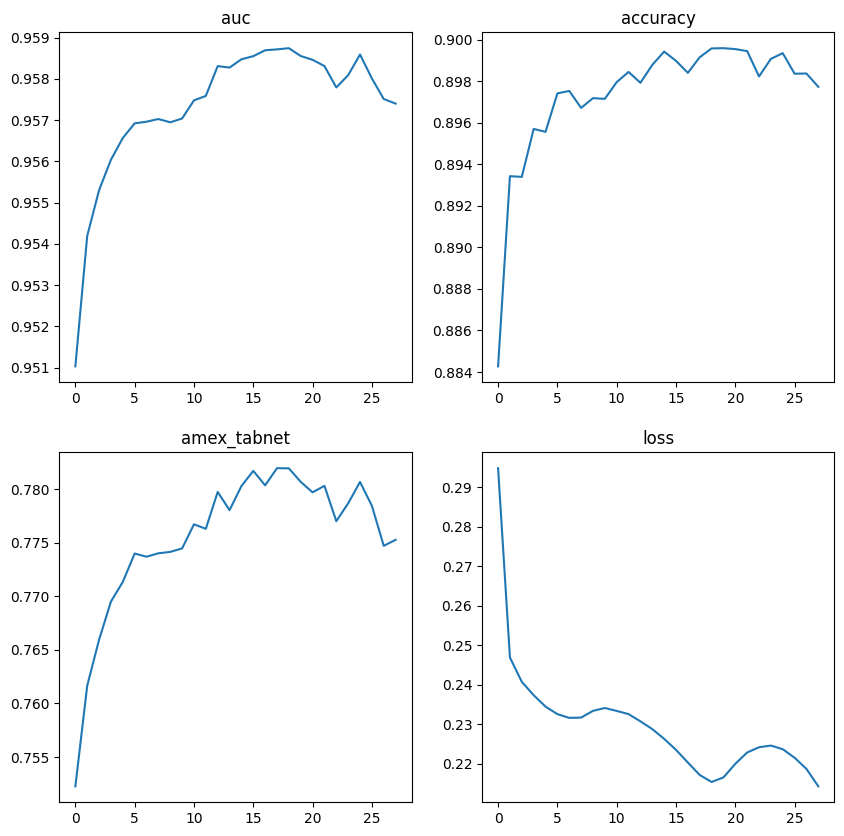

In [ ]:
fig, axs = plt.subplots(2, 2 , figsize=(10,10))

axs[0, 0].plot(models[-1].history['val_0_auc'])
axs[0, 0].set_title('auc')
axs[1, 1].plot(models[-1].history['loss'])
axs[1, 1].set_title('loss')
axs[0, 1].plot(models[-1].history['val_0_accuracy'])
axs[0, 1].set_title('accuracy')
axs[1, 0].plot(models[-1].history['val_0_amex_tabnet'])
axs[1, 0].set_title('amex_tabnet')

# Importances (Global)

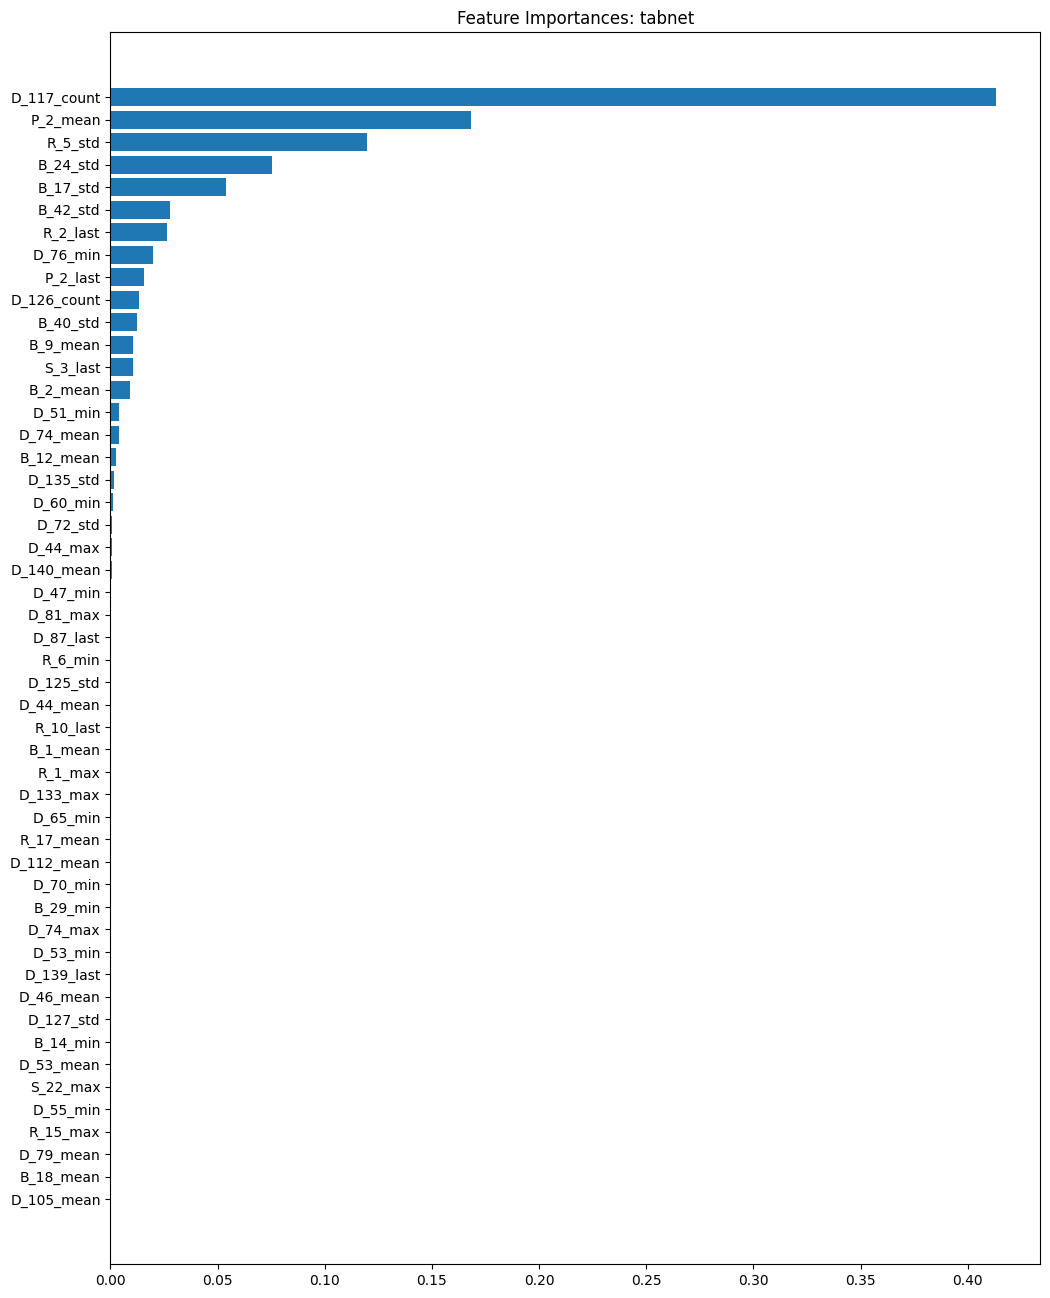

In [ ]:
features_importances = models[-1].feature_importances_
argsort = np.argsort(features_importances)
features_importances_sorted = features_importances[argsort]

feature_names = train[all_features].columns
features_sorted = feature_names[argsort]

# plot feature importances
plt.figure(figsize = (12, 16))

### n features to plot
n = 50

plt.barh(features_sorted[-n:], features_importances_sorted[-n:])
plt.title(f"Feature Importances: {CFG.model}");

NameError: ignored

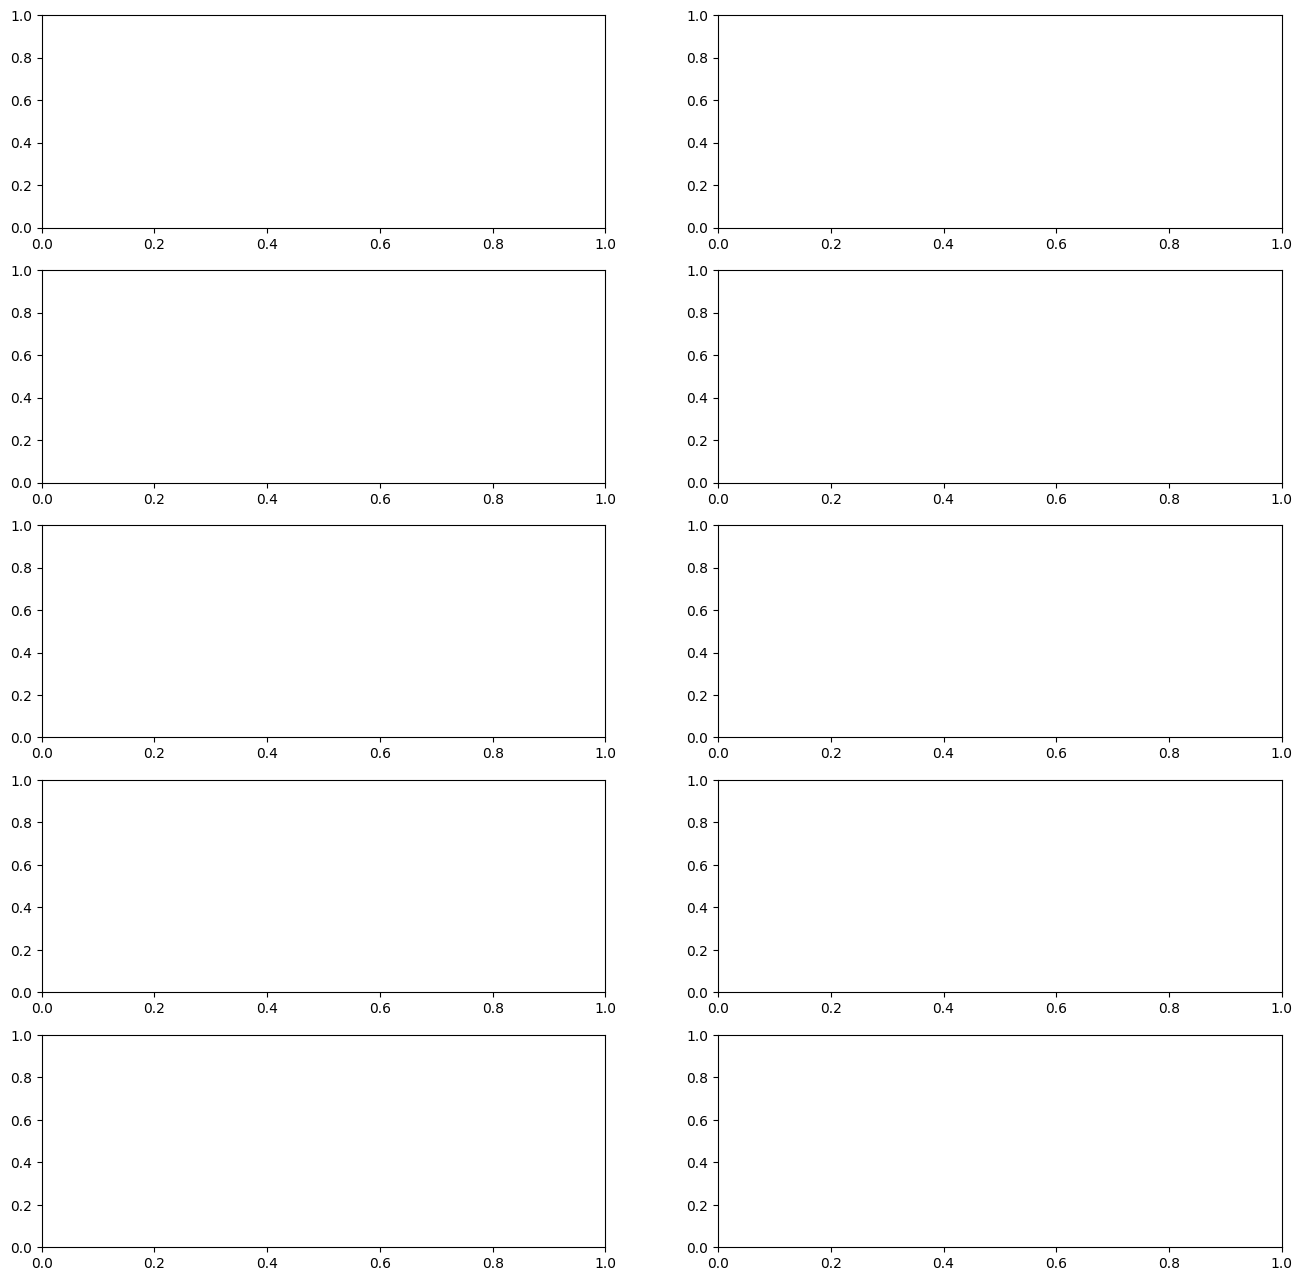

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(16,16))
axs = axs.flatten()

k=-1    
for i, (mask, j) in enumerate(zip(masks_, axs)):
    sns.heatmap(mask[:150], ax=j)
    if i%2 == 0:
        k+=1
    j.set_title((f"Fold{k} Mask for First 150 Instances"))
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(len(explain_matrices), 1, figsize=(20,8))
for i,matrix in enumerate(explain_matrices):
    axs[i].set_title(f'Fold{i} Explain Matrix for First 150 Instances')
    sns.heatmap(matrix[:150], ax=axs[i])
plt.tight_layout() 

In [19]:
!pip install rtdl
!pip install libzero==0.0.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

In [21]:
device = torch.device('cuda')

zero.improve_reproducibility(seed=123456)

123456

In [22]:
X.head(10)

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
0,0.934745,0.0,0.934745,0.934745,0.934745,0.0,0.0,0,0,0,...,1,1,0,1,1,-1,1,1,6,1
1,0.880519,0.0,0.880519,0.880519,0.880519,6.0,0.0,6,6,6,...,1,1,0,1,1,-1,1,1,6,1
2,0.880875,0.0,0.880875,0.880875,0.880875,0.0,0.0,0,0,0,...,1,1,2,1,1,-1,1,1,6,1
3,0.621776,0.0,0.621776,0.621776,0.621776,0.0,0.0,0,0,0,...,1,1,0,1,1,-1,1,1,3,1
4,0.871900,0.0,0.871900,0.871900,0.871900,0.0,0.0,0,0,0,...,1,1,0,1,1,1,1,1,6,1
5,0.824061,0.0,0.824061,0.824061,0.824061,0.0,0.0,0,0,0,...,1,1,2,1,1,-1,1,1,6,1
6,0.477116,0.0,0.477116,0.477116,0.477116,0.0,0.0,0,0,0,...,1,1,2,1,1,-1,1,1,3,1
7,1.009762,0.0,1.009762,1.009762,1.009762,0.0,0.0,0,0,0,...,1,1,2,1,1,-1,1,1,5,1
8,0.424624,0.0,0.424624,0.424624,0.424624,18.0,0.0,18,18,18,...,1,1,3,1,1,1,1,1,6,1
9,0.359892,0.0,0.359892,0.359892,0.359892,0.0,0.0,0,0,0,...,1,1,0,1,1,-1,1,1,5,1


In [23]:
task_type = 'binclass'

assert task_type in ['binclass', 'multiclass', 'regression']

X_all = X.astype('float32')
y_all = y.astype('float32' if task_type == 'regression' else 'int64')
if task_type != 'regression':
    y_all = sklearn.preprocessing.LabelEncoder().fit_transform(y_all).astype('int64')
n_classes = int(max(y_all)) + 1 if task_type == 'multiclass' else None

X = {}
y = {}

X['train'], X['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
    X_all, y_all, train_size=0.8)
    

preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}


if task_type == 'regression':
    y_mean = y['train'].mean().item()
    y_std = y['train'].std().item()
    y = {k: (v - y_mean) / y_std for k, v in y.items()}
else:
    y_std = y_mean = None

if task_type != 'multiclass':
    y = {k: v.float() for k, v in y.items()}

In [24]:
d_out = n_classes or 1

model = rtdl.FTTransformer.make_default(
    n_num_features=X_all.shape[1],
    cat_cardinalities=None,
    last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
    d_out=d_out)

model.to(device)

optimizer = (
    model.make_default_optimizer()
    if isinstance(model, rtdl.FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay))

loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss)

In [25]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.')

In [ ]:
# a = np.array([0,0,0,0,1,0,0])
# b = np.array([1,1,1,1,1,1,1])

# Amex_transf()(a,b[...,None])

0.10457516339869281

In [26]:
@torch.no_grad()

def evaluate(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 128):
        prediction.append(apply_model(batch))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score

batch_size = 128

train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 0.2575


In [27]:
path = F"/content/drive/MyDrive/TabNet/my_checkpoint.pth.tar"
path_optimizer = F"/content/drive/MyDrive/TabNet/my_checkpoint_optimizer.pth.tar"

n_epochs = 5
load_model = True #Downloading model's params
report_frequency = len(X['train']) // batch_size // 3

if load_model:
    model.load_state_dict(torch.load(path))
    optimizer.load_state_dict(torch.load(path_optimizer))

for epoch in range(1, n_epochs + 1):

    if epoch % 3 == 0:
        print("==> Saving Checkpoint <==")
        torch.save(model.state_dict(), path)
        torch.save(optimizer.state_dict(), path_optimizer)

    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()
        if iteration % report_frequency == 0:
            print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

    test_score = evaluate('test')
    print(f'Epoch {epoch:03d} | Test score: {test_score:.4f}', end='')
    progress.update((-1 if task_type == 'regression' else 1) * test_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

(epoch) 1 (batch) 0 (loss) 0.2418
(epoch) 1 (batch) 956 (loss) 0.2503
(epoch) 1 (batch) 1912 (loss) 0.2428
(epoch) 1 (batch) 2868 (loss) 0.1029
Epoch 001 | Test score: 0.8956 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.2249
(epoch) 2 (batch) 956 (loss) 0.2497
(epoch) 2 (batch) 1912 (loss) 0.2208
(epoch) 2 (batch) 2868 (loss) 0.0723
Epoch 002 | Test score: 0.8953
(epoch) 3 (batch) 0 (loss) 0.2414
(epoch) 3 (batch) 956 (loss) 0.2372
(epoch) 3 (batch) 1912 (loss) 0.2698
(epoch) 3 (batch) 2868 (loss) 0.0798
Epoch 003 | Test score: 0.8959 <<< BEST VALIDATION EPOCH
(epoch) 4 (batch) 0 (loss) 0.2449
(epoch) 4 (batch) 956 (loss) 0.2364
(epoch) 4 (batch) 1912 (loss) 0.2295
(epoch) 4 (batch) 2868 (loss) 0.1040
Epoch 004 | Test score: 0.8965 <<< BEST VALIDATION EPOCH
==> Saving Checkpoint <==
(epoch) 5 (batch) 0 (loss) 0.2338
(epoch) 5 (batch) 956 (loss) 0.2678
(epoch) 5 (batch) 1912 (loss) 0.1985
(epoch) 5 (batch) 2868 (loss) 0.0589
Epoch 005 | Test score: 0.8946


In [29]:
true = y['test']
preds = apply_model(X['test'][...,None])

preds 

# Amex_tabnet()(true,preds)
# [...,None]

OutOfMemoryError: ignored

![ensemble-ml.jpeg](attachment:ensemble-ml.jpeg)